## Before Running the Following:
The following code can all be ran, assuming the following has been fulfilled.
- The entirety of the 'ecfp_dataset_builder.ipynb has been ran OR a corresponding 'fps_and_labels.pickle' file has already been created
- This file is in the same folder as the 'fps_and_labels.pickle' file.
- All imported python packages have already been installed.

In [8]:
import pickle
import matplotlib.pyplot as plt
import random
import numpy as np
import networkx as nx
from sklearn.decomposition import PCA
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

## Dataset

Upon construction, our dataset class randomly saves ~10% of the full dataset (at random), to be tested on. This allows us to seperate testing and training data to assess the quality of our predictive model.

In [15]:
class FpsDataset(Dataset):
        
    def __init__(self, fingerprints, labels):
        fps = fingerprints.copy()
        lbls = labels.copy()
        pca = PCA(n_components=32) # reduce data set vector length to 32
        pca_fps = pca.fit_transform(fps)
        # hardcoded 781 data pts for testing data
        testing_idxs = random.sample(range(7807), 781)
        training_idxs = [x for x in list(range(7807)) if x not in testing_idxs]
        self.training_tens = torch.tensor(pca_fps[training_idxs,:]).float()
        self.test_tens = torch.tensor(pca_fps[testing_idxs,:]).float()
        self.tr_label_tens = torch.tensor(lbls[training_idxs]).float()
        self.te_label_tens = torch.tensor(lbls[testing_idxs]).float()
        self.sample_count = lbls.shape[0]
    
    def __len__(self):
        return len(self.tr_label_tens)
        
    def __getitem__(self, idx):
        return self.training_tens[idx], self.tr_label_tens[idx]

Some of the following is commented out, as it is a "Google Colab" specific implementation detail.

In [16]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

with open('fps_and_labels.pickle', 'rb') as f:
  fingerprints, labels = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
def unpickle_fps_data(path='fps_and_labels.pickle'):
    with open('fps_and_labels.pickle', 'rb') as f:
        fingerprints, labels = pickle.load(f)
    return (fingerprints, labels)

# NN Implementatio
The following code is the implementation of our final NN benchmark. It was ran for 2000 epochs with a batch size of 256. The data input vectors are of length 32, each representing one molecule. The classifier for this expriment was optimized in experiments done later in the document.
## Setup

In [18]:
# Setup: Data, Error func, optimizer, NN classifier
# 1. Data

#fingerprints, labels = unpickle_fps_data() 

dataset = FpsDataset(fingerprints, labels) # initialize dataset obj
# creates a dataloader to batch data
dataloader = DataLoader(dataset=dataset, batch_size=256, shuffle=True)
# 2. Error
err_func = torch.nn.MSELoss()
# 3. Classifier
classifier = torch.nn.Sequential(
    torch.nn.Linear(32,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,32),
    torch.nn.SiLU(),
    torch.nn.Linear(32,16),
    torch.nn.SiLU(),
    torch.nn.Linear(16,1)  
)
# 4. Optimizer
optimizer = torch.optim.Adam(classifier.parameters(), 0.001)

## Training Loop

In [19]:
epochs = 2000
loss_list = []
accuracy_list = []

# Training loop:
for i in range(epochs):
    # loop through training batches
    for idx, (data, y) in enumerate(dataloader):
        optimizer.zero_grad()
        predictions = torch.sigmoid(classifier(data))
        error = err_func(predictions, y.reshape((y.size(0),1))) 
        error.backward()
        optimizer.step()
    # track error over whole dataset per epoch
    predictions = torch.sigmoid(classifier(dataset.training_tens))
    loss_list.append(err_func(predictions, dataset.tr_label_tens.reshape(
        dataset.tr_label_tens.size(0),1)).detach().numpy())
    # track error over tests per epoch
    predictions = torch.sigmoid(classifier(dataset.test_tens))
    test_predictions = predictions.reshape(-1).detach().numpy().astype(int)
    test_labels = dataset.te_label_tens.detach().numpy()
    total_correct = 0
    for i in range(781):
        if test_predictions[i] == test_labels[i]:
            total_correct += 1
    accuracy_list.append(total_correct/7.81)

In [20]:
def get_accuracy(clss, fps_dataset):
    predictions = torch.sigmoid(clss(fps_dataset.test_tens))
    test_predictions = predictions.reshape(-1).detach().numpy().astype(int)
    test_labels = fps_dataset.te_label_tens.detach().numpy()
    total_correct = 0
    for i in range(781):
        if test_predictions[i] == test_labels[i]:
            total_correct += 1
    return total_correct/7.81

### Results

The results of our experiments were that we ended with an accuracy on testing data of 80.5%. This means, on data which the NN was not trained on, it was able to accurately predict BBB permiability 80.5% of the time.

In [21]:
print("Final Accuracy: %f" % get_accuracy(classifier, dataset))

Final Accuracy: 80.537772


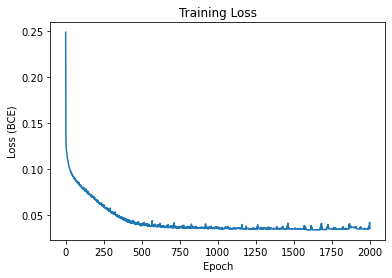

In [22]:
plt.plot(list(range(1, epochs+1)), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Training Loss')
plt.show()

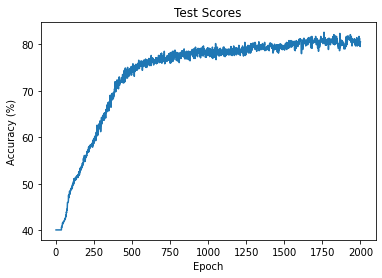

In [23]:
plt.plot(list(range(1, epochs+1)), accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Scores')
plt.show()

# Classifier Hyperparam Testing

The following test were ran as a means of improving out classifier implementation. All in all, we discovered a four layer NN with SiLu as the non-linear activation function worked best. The testing was not exhaustive but did improve the quality of the classifier's predictions.

### Classifier Testing Helper Method

In [32]:
def test_classifiers(classifier, epochs, batch_size):
    # Setup: Data, Error func, optimizer, NN classifier
    # 1. Data
    dataset = FpsDataset(fingerprints, labels) # initialize/load dataset obj
    # creates a dataloader to batch data
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    # 2. Error
    err_func = torch.nn.BCELoss()
    # 3. Classifier
    classifier = classifier
    # 4. Optimizer
    optimizer = torch.optim.Adam(classifier.parameters(), 0.001)
    
    # Training loop:
    for i in range(epochs):
        # loop through training batches
        for idx, (data, y) in enumerate(dataloader):
            optimizer.zero_grad()
            predictions = torch.sigmoid(classifier(data))
            error = err_func(predictions, y.reshape((y.size(0),1))) 
            error.backward()
            optimizer.step()
    # calc % error  
    total_correct = 0
    predictions = torch.sigmoid(classifier(dataset.test_tens))
    test_predictions = predictions.reshape(-1).detach().numpy().astype(int)
    test_labels = dataset.te_label_tens.detach().numpy()
    for i in range(781):
      if test_predictions[i] == test_labels[i]:
          total_correct += 1
    # return: classifier, error_list, and percent correct on test
    return total_correct/7.81

## Non-Lin Func tests

The following tests compared the quality of predictions of NN models with the ReLU, ELU, and Silu non-linear functions respectivley. SiLu turned out to yeild the most accurate results.

In [38]:
relu_cl = torch.nn.Sequential(
    torch.nn.Linear(32,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,16),
    torch.nn.ReLU(),
    torch.nn.Linear(16,1)  
)
elu_cl = torch.nn.Sequential(
    torch.nn.Linear(32,64),
    torch.nn.ELU(),
    torch.nn.Linear(64,32),
    torch.nn.ELU(),
    torch.nn.Linear(32,16),
    torch.nn.ELU(),
    torch.nn.Linear(16,1)  
)
silu_cl = torch.nn.Sequential(
    torch.nn.Linear(32,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,32),
    torch.nn.SiLU(),
    torch.nn.Linear(32,16),
    torch.nn.SiLU(),
    torch.nn.Linear(16,1)  
)

non_lin_list = [relu_cl,elu_cl,silu_cl]
relu = []
elu = []
silu = []
results = [relu, elu, silu]
for i in range(10):
    j = 0
    for cl in non_lin_list:
        results[j].append(test_classifiers(cl, 150, 256))
        j+=1

<BarContainer object of 3 artists>

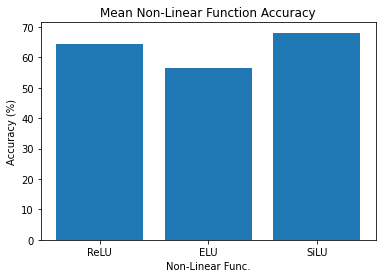

In [43]:
plt.xlabel('Non-Linear Func.')
plt.ylabel('Accuracy (%)')
plt.title('Mean Non-Linear Function Accuracy')
plt.bar(["ReLU","ELU","SiLU"], [np.mean(relu), np.mean(elu), np.mean(silu)])

## Hidden Layer Number Tests

The following tests compared the quality of predictions of NN models with a range of hidden layers. We only tested NN's with 3, 4, and 5 layers due to time constraints, but 4 layers performed with the highest accuracy.

In [41]:
thr_cl = torch.nn.Sequential(
    torch.nn.Linear(32,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,32),
    torch.nn.SiLU(),
    torch.nn.Linear(32,1), 
)
four_cl = torch.nn.Sequential(
    torch.nn.Linear(32,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,32),
    torch.nn.SiLU(),
    torch.nn.Linear(32,16),
    torch.nn.SiLU(),
    torch.nn.Linear(16,1)  
)
five_cl = torch.nn.Sequential(
    torch.nn.Linear(32,64),
    torch.nn.SiLU(),
    torch.nn.Linear(64,32),
    torch.nn.SiLU(),
    torch.nn.Linear(32,16),
    torch.nn.SiLU(),
    torch.nn.Linear(16,8),  
    torch.nn.SiLU(),
    torch.nn.Linear(8,1)
)
layer_list = [thr_cl,four_cl,five_cl]
thr = []
four = []
five = []
results = [thr, four, five]
for i in range(10):
    j = 0
    for cl in layer_list:
        results[j].append(test_classifiers(cl, 150, 256))
        j+=1

<BarContainer object of 3 artists>

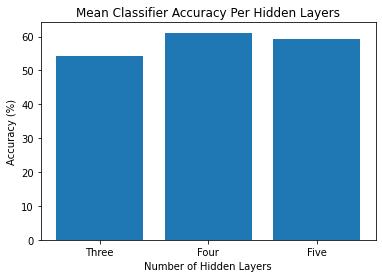

In [44]:
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy (%)')
plt.title('Mean Classifier Accuracy Per Hidden Layers')
plt.bar(["Three","Four","Five"], [np.mean(thr), np.mean(four), np.mean(five)])